In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.losses import mse
from keras.utils import plot_model
from keras import backend as K
from keras.layers import BatchNormalization, Activation, Flatten
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.preprocessing.image import array_to_img, img_to_array, load_img

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os

from PIL import Image

In [0]:
#ヒートマップの描画
def save_img(x_normal, x_anomaly, img_normal, img_anomaly):
    path = 'images/'
    if not os.path.exists(path):
          os.mkdir(path)

    #　※注意　評価したヒートマップを1～10に正規化
    img_max = np.max([img_normal, img_anomaly])
    img_min = np.min([img_normal, img_anomaly])
    img_normal = (img_normal-img_min)/(img_max-img_min) * 9 + 1
    img_anomaly = (img_anomaly-img_min)/(img_max-img_min) * 9 + 1

    plt.figure()
    plt.subplot(2, 2, 1)
    plt.imshow(x_normal[0,:,:,0], cmap='gray')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.imshow(img_normal[0,:,:,0], cmap='Blues',norm=colors.LogNorm())
    plt.axis('off')
    plt.colorbar()
    plt.clim(1, 10)

    plt.subplot(2, 2, 3)
    plt.imshow(x_anomaly[0,:,:,0], cmap='gray')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.imshow(img_anomaly[0,:,:,0], cmap='Blues',norm=colors.LogNorm())
    plt.axis('off')
    plt.colorbar()
    plt.clim(1, 10)

    plt.savefig(path +"result.png")
    plt.show()
    plt.close()

In [0]:
#ヒートマップの計算
def evaluate_img(model, x_normal, x_anomaly, height=8, width=8, move=2):
    img_normal = np.zeros((x_normal.shape))
    img_anomaly = np.zeros((x_normal.shape))

    for i in range(int((x_normal.shape[1]-height)/move)+1):
        for j in range(int((x_normal.shape[2]-width)/move)+1):
            x_sub_normal = x_normal[0, i*move:i*move+height, j*move:j*move+width, 0]
            x_sub_anomaly = x_anomaly[0, i*move:i*move+height, j*move:j*move+width, 0]
            x_sub_normal = x_sub_normal.reshape(1, height, width, 1)
            x_sub_anomaly = x_sub_anomaly.reshape(1, height, width, 1)

            #正常のスコア
            mu, sigma = model.predict(x_sub_normal, batch_size=1, verbose=0)
            loss = 0
            for k in range(height):
                for l in range(width):
                    loss += 0.5 * (x_sub_normal[0,k,l,0] - mu[0,k,l,0])**2 / sigma[0,k,l,0]
            img_normal[0, i*move:i*move+height, j*move:j*move+width, 0] +=  loss

            #異常のスコア
            mu, sigma = model.predict(x_sub_anomaly, batch_size=1, verbose=0)
            loss = 0
            for k in range(height):
                for l in range(width):
                    loss += 0.5 * (x_sub_anomaly[0,k,l,0] - mu[0,k,l,0])**2 / sigma[0,k,l,0]
            img_anomaly[0, i*move:i*move+height, j*move:j*move+width, 0] +=  loss

    save_img(x_normal, x_anomaly, img_normal, img_anomaly)


In [0]:
# 8×8のサイズにランダム切り出す
def cut_img(x, number, height=8, width=8):
    print("cutting images ...")
    x_out = []
    x_shape = x.shape

    for i in range(number):
        shape_0 = np.random.randint(0, x_shape[0])
        shape_1 = np.random.randint(0, x_shape[1] - height)
        shape_2 = np.random.randint(0, x_shape[2] - width)
        temp = x[shape_0, shape_1 : shape_1 + height, shape_2 : shape_2 + width, 0]
        x_out.append(temp.reshape((height, width, x_shape[3])))

    print("Complete.")
    x_out = np.array(x_out)

    return x_out

In [0]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls  /content/gdrive/'My Drive'/images/コネクタ/ok

IMG_0583.JPG  IMG_0585.JPG  IMG_0587.JPG  IMG_0589.JPG
IMG_0584.JPG  IMG_0586.JPG  IMG_0588.JPG  IMG_0590.JPG


In [0]:
okDir = "/content/gdrive/My Drive/images/コネクタ/ok"
ngDir = "/content/gdrive/My Drive/images/コネクタ/ng"

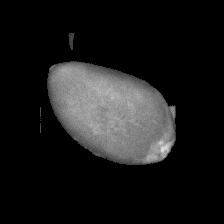

In [0]:
def BlackBack(image_array):
  im_bool = image_array > 50
  ret = image_array * im_bool
  return ret

im = np.array(Image.open( "/content/gdrive/My Drive/images/pumpkin_20181214/ok/20181204103724257.bmp"))
im = BlackBack(im)
Image.fromarray(im)


In [0]:
from pathlib import Path
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def list_images(path):
  p = Path(path)
  return p.glob("*.bmp")

def GetImageList(path, size):
  image_array_list = []
  for f in list_images(path):
    image = load_img(f, target_size=(size, size), color_mode = "grayscale")
    image_array = img_to_array(image)
    image_array = BlackBack(image_array)
    image_array = image_array.astype('float32') / 255
    image_array_list.append(image_array)
  return image_array_list

def GetImageArray(path, size):
  return np.asarray(GetImageList(path, size))

In [0]:
# コネクタデータセット
okDir = "/content/gdrive/My Drive/images/コネクタ/ok"
ngDir = "/content/gdrive/My Drive/images/コネクタ/ng"

x_train_con_ok = GetImageArray(okDir, 256)
x_test_con_ok = GetImageArray(okDir, 256)
x_test_con_ng = GetImageArray(ngDir, 256)

print('train {}, x_test {}, y_test {}'.format(x_train_con_ok.shape[0], x_test_con_ok.shape[0], x_test_con_ng.shape[0]))

train 0, x_test 0, y_test 0


In [0]:
# 種子データセット
okDir = "/content/gdrive/My Drive/images/pumpkin_20181214/ok"
ngDir = "/content/gdrive/My Drive/images/pumpkin_20181214/ng"

seed_images = GetImageList(okDir, 224)
x_train_seed = np.asarray(seed_images[:300])

x_test_seed_ok_images = seed_images[315:]
x_test_seed_ok = np.asarray(x_test_seed_ok_images)
y_test_seed_ok = np.zeros(len(x_test_seed_ok_images))

x_test_seed_ng_imges =  GetImageList(ngDir, 224)[:5]
x_test_seed_ng = np.asarray(x_test_seed_ng_imges)
y_test_seed_ng = np.ones(len(x_test_seed_ng_imges))

x_test_seed = np.asarray(x_test_seed_ok_images + x_test_seed_ng_imges)
y_test_seed = np.hstack((y_test_seed_ok, y_test_seed_ng))

print('train {}, x_test {}, y_test {}'.format(x_train_seed.shape[0], x_test_seed.shape[0], y_test_seed.shape[0]))

train 300, x_test 10, y_test 10


In [0]:
# network parameters
size = 16
input_width = size
input_height = size
input_shape=(input_width, input_height, 1)
batch_size = 128
latent_dim = 128
epochs = 10
Nc = 16

#data set
#x_train = x_train_con_ok
x_train = x_train_seed

x_train_shape = x_train.shape

x_train_cutted = cut_img(x_train, 100000, height=input_height, width=input_width)
print("train data:",len(x_train_cutted))

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(Nc, kernel_size=2, strides=2)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(2*Nc, kernel_size=2, strides=2)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Flatten()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(input_width)(latent_inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Reshape((4, 4, 1))(x)
x = Conv2DTranspose(2*Nc, kernel_size=2, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2DTranspose(Nc, kernel_size=2, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x1 = Conv2DTranspose(1, kernel_size=4, padding='same')(x)
x1 = BatchNormalization()(x1)
out1 = Activation('sigmoid')(x1) #out.shape=(n,8,8,1)

x2 = Conv2DTranspose(1, kernel_size=4, padding='same')(x)
x2 = BatchNormalization()(x2)
out2 = Activation('sigmoid')(x2) #out.shape=(n,8,8,1)

decoder = Model(latent_inputs, [out1, out2], name='decoder')
#decoder.summary()

# build VAE model
outputs_mu, outputs_sigma_2 = decoder(encoder(inputs)[2])
vae = Model(inputs, [outputs_mu, outputs_sigma_2], name='vae_mlp')

# VAE loss
m_vae_loss = (K.flatten(inputs) - K.flatten(outputs_mu))**2 / K.flatten(outputs_sigma_2)
m_vae_loss = 0.5 * K.sum(m_vae_loss)

a_vae_loss = K.log(2 * 3.14 * K.flatten(outputs_sigma_2))
a_vae_loss = 0.5 * K.sum(a_vae_loss)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(kl_loss + m_vae_loss + a_vae_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# train the autoencoder
vae.fit(x_train_cutted,
        epochs=epochs,
        batch_size=batch_size)
vae.save_weights('vae_mlp_mnist.h5')

cutting images ...
Complete.
train data: 100000
Epoch 1/10
100000/100000 [==============================] - 34s 339us/step - loss: 35100.8702
Epoch 2/10
100000/100000 [==============================] - 17s 166us/step - loss: 23210.9979
Epoch 3/10
100000/100000 [==============================] - 17s 165us/step - loss: 22160.6374
Epoch 4/10
100000/100000 [==============================] - 17s 166us/step - loss: 20923.6662
Epoch 5/10
100000/100000 [==============================] - 17s 166us/step - loss: 19273.5239
Epoch 6/10
100000/100000 [==============================] - 18s 182us/step - loss: 16930.0085
Epoch 7/10
100000/100000 [==============================] - 16s 165us/step - loss: 13437.8411
Epoch 8/10
100000/100000 [==============================] - 17s 165us/step - loss: 8043.6495
Epoch 9/10
100000/100000 [==============================] - 17s 165us/step - loss: 23.4510
Epoch 10/10
100000/100000 [==============================] - 17s 166us/step - loss: -10538.5421


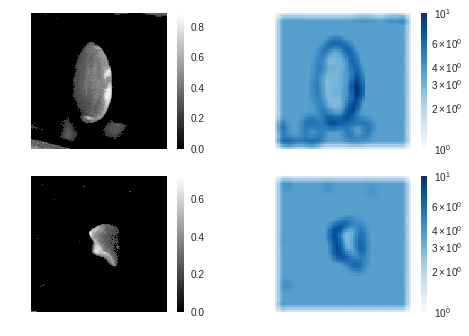

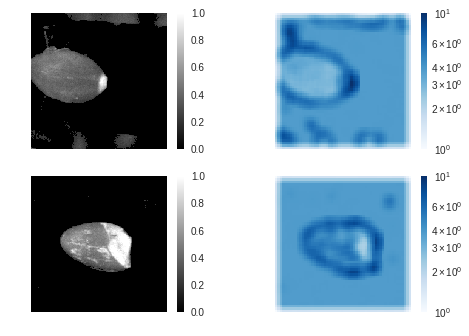

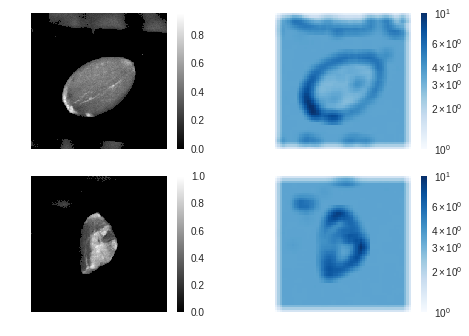

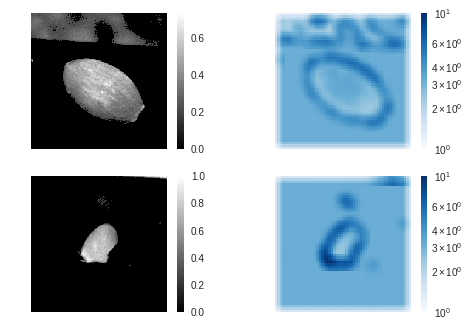

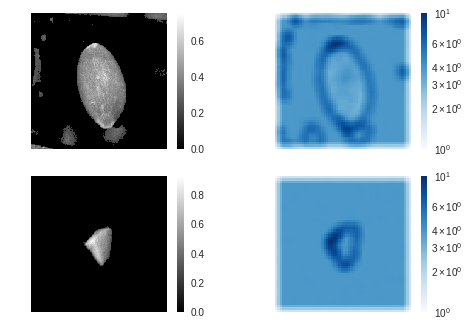

In [0]:
#正常/異常のテストデータ
evaluteResult = []
#x_test_ok =x_test_con_ok
#x_test_ng = x_test_con_ng

x_test_ok = x_test_seed_ok
x_test_ng = x_test_seed_ng

for i in range(len(x_test_ok)):
  test_normal = x_test_ok[i].reshape(1,  x_test_ok[i].shape[0],  x_test_ok[i].shape[1],  x_test_ok[i].shape[2])
  test_anomaly =  x_test_ng[i].reshape(1, x_test_ng[i].shape[0], x_test_ng[i].shape[1], x_test_ng[i].shape[2])

  evaluteResult.append(evaluate_img(vae, test_normal, test_anomaly, height=input_height, width=input_width, move=4))
#  test_normal = im.reshape(1, im.shape[0], im.shape[1], im.shape[2])
#  evaluteResult.append(evaluate_img(vae, test_normal))